We are creating a dataset which is based on all of the dual-task trials per block and we are ignoring the practice trials
The dataset is built by merging the results acquired in the paper created by Chris.

Some columns are based on the significance provided in the said paper ( & maybe image here)
The csv files we are merging into our dataset are provided below

- MaxDeviationPerTrial.csv
- maxnrDigitEnteredPerPPAndPerBlockPerTrial.csv
- numberOfVisitsTrackerPerParticipantPerBlock.csv (trial data)
- samplesOutsideTrial.csv(*)
- sdVisTime.csv(*)
- tableForMeanTimeInDigitPerPPandPerBlock.csv(*) - merge the data ber block maybe?
- We are using the payoff function values provided in the meanVisTime.csv file
- The columns marked with star could be significant and we are testing to see the results with or without the said feature

## 0. Load the data

In [1]:
# We first read the data and display it
from sklearn.utils import shuffle
final_rows = []

output_dist = 'distance'
output_pred = 'prediction'

import pandas as pd

test = False

data = pd.read_csv('./data.csv');

if test:
    data = shuffle(data)
    data = data.head(500)


display(data.head(10))

display('Loaded the data!')

,TrialNumber,PayOffFunction,Radius,Noise,IKINumber,MeanDeviation,MaxDeviation,MeanNrDigits,MaxNrDigits,MeanTimeTypingWindow,MaxTimeTypingWindow,MeanTrackingTime,MaxTrackingTime,TrackingWindowVisitCounter
0,107,Speed,80,3,0.308554,31.836899,76.66,5.000000,6,2.079050,2.8536,1.331467,1.6520,3
1,108,Speed,80,3,0.308554,16.518333,44.27,6.666667,9,2.111167,2.3783,1.001200,1.0343,2
2,109,Speed,80,3,0.308554,26.661194,69.16,6.666667,8,2.060633,2.4747,1.342900,1.3780,2
3,110,Speed,80,3,0.308554,36.799188,71.33,10.000000,11,3.286850,3.3149,1.582600,1.5826,1
4,111,Speed,80,3,0.308554,15.096851,37.37,5.000000,7,2.154425,3.6314,0.989533,1.1029,3
5,112,Speed,80,3,0.308554,27.756481,66.45,5.000000,9,1.934700,3.3108,1.377100,1.5838,3
6,113,Speed,80,3,0.308554,27.953079,69.58,5.000000,10,1.928625,4.0674,1.331167,1.4453,3
7,114,Speed,80,3,0.308554,14.232909,45.58,5.000000,7,1.628350,2.4539,1.011167,1.1714,3
8,115,Speed,80,3,0.308554,29.031232,70.15,10.000000,11,2.936750,2.9834,1.308100,1.3081,1
9,116,Speed,80,3,0.308554,30.585000,63.01,6.666667,9,2.193600,2.6000,1.172250,1.2398,2


'Loaded the data!'

## 1. Split the data into 8 data sets
We first split the data into 8 datasets and we calculate the mean value for each of the datasetin order to see how biased the data is in terms of Radius, Noise and the payoff function

In [2]:
split_on = ['PayOffFunction','Radius','Noise']

def split(dataSets,col):
    
    s = []
    
    for data in dataSets:
        
        if(col >= len(split_on)):
            return None
        
        values = {}
        
        for row in range(0,data.shape[ 0 ]):
            splitColumn = split_on[ col ]

            rowValue = data.iloc[ row ][ splitColumn ]
            
            if not rowValue in values:
                values[ rowValue ] = [ ]
                
            values[ rowValue ].append(row)
            
        for value in values:
            nextSet = []
            
            for row in values[value]:
                nextSet.append(data.iloc[ row ])
                
            s.append(pd.DataFrame(nextSet))
    res = split( s , col + 1 )
    
    if res is None:
        return s
    else: 
        return res
    
sets = [ data ]

split_sets = split(sets,0)

#for debug
#i = 0
#for item in split_sets:
#    item.to_csv('dataset_' + str(i) + '.csv')
#    i = i + 1

print('resulting length : ' +  str(len(split_sets)))


resulting length : 8


In [3]:

#We then take the top N percent of each of the sets

def get_by_split(sets,start, step, end, func):
    
    while start <= end:
    
        for dataSet in sets:
            func(start,dataSet)
            
        start = start + step

per_tick = {}

#we save all of the datasets in this variable for later use
datasets = []

#We then compute the mean for the score column for the provided dataset
def mean(current_tick,item):

    #meanVal = item['Score'].mean()
    
    #if current_tick not in per_tick:
    #    per_tick[current_tick]= []
   #     
   # per_tick[current_tick].append(meanVal)
    datasets.append(item)

get_by_split(split_sets, 1, 0.05, 1,mean)

In [4]:

d = []

for dataset in datasets:
    newset = shuffle(dataset, random_state = 42)
    d.append(newset)
    
datasets = d

## 2. For each of the produced datasets we can now compute different statististics.
Currently we are computing and plotting the mean value.

In [5]:
# We can now measure the distributions
# by testing different sizes

import matplotlib.pyplot as plt
import numpy as np

for tick_size in per_tick:
    tick_marks = np.arange(len(per_tick[tick_size]))
    fig, ax = plt.subplots()
    plt.bar(tick_marks,per_tick[tick_size])
    plt.show()

In [6]:
dictionary = {}

i = 0;
perc = 10
rowCounter = 0

print( 'there are ' + str(len(datasets)) + ' datasets' )

while(i <= 9):
    
    print('starting to aquire chunk ' + str(i))
    
    rp = []

    for next_set in datasets:
        size = int(next_set.shape[0] / perc)
        
        #starting point
        take = i * size
        start = take
        end = take + size
        next_items = next_set[start:end]
        
        frame = pd.DataFrame(next_items,columns=next_set.columns)
        rp.append(frame)
        
    dictionary[ i ] = pd.concat(shuffle(rp, random_state = 42))
    
    i = i + 1
    
display(dictionary[0].shape)
    
print('done partitioning in chunks')

there are 8 datasets
starting to aquire chunk 0
starting to aquire chunk 1
starting to aquire chunk 2
starting to aquire chunk 3
starting to aquire chunk 4
starting to aquire chunk 5
starting to aquire chunk 6
starting to aquire chunk 7
starting to aquire chunk 8
starting to aquire chunk 9


(192, 14)

done partitioning in chunks


## 3. Then we split the data by using cross-sampling and we use cross-validation

The idea behind this is that we want to have equal distribution of the data in order to avoid the model becoming biased towards certain characteristics. We also remove some of the columns that are not neccessary when training our model.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit

def cross_validate(func, label, ignore_columns):
 splits = {}
 k = 0
 
 best_score = -999999
 model_y = None
 ordered_dataset = None
 print('Begin training classifier')

 result_items = []

 for k in dictionary:
     test_set = dictionary[k]
     train_q = [test_set]
    
     for key in dictionary:
         if key == k: 
             continue
         train_q.append(dictionary[key])
        
     train_data = pd.concat(train_q)
     re_insert = {}
    
     for i in ignore_columns:
        re_insert[i] = train_data[i]
        train_data = train_data.drop(i,1)
        
     y = train_data[ label ]
     X = train_data.drop( label , 1 )
     
     indic = []
    
     for i in range(0, X.shape[0]):
        if i < test_set.shape[0]:
            indic.append(1)
        else:
            indic.append(-1)
                
     #https://stackoverflow.com/questions/31948879/using-explict-predefined-validation-set-for-grid-search-with-sklearn
     ps = PredefinedSplit(test_fold=indic)
     
     result = func(X, y, ps)
        
     for col in ignore_columns:
         result[0].X[col]=re_insert[col]
    
     result_items.append(result[0])
     
 return result_items

## 4. Create a support vector classifier and initialize

We also create a grid which is used to search for the best model.

In [8]:
from sklearn.svm import SVC
from sklearn.tree import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

sv = SVC(cache_size=7000)

from sklearn.model_selection import GridSearchCV

dict_grid = {
    #sv :  {'kernel' : ['linear'] }
    sv: [
            {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100]},
           {'kernel': ['linear'], 'C': [1, 10, 100]}
    ]
}

## 5. We train the model using the provided grid

After the training is finished and we compute the distance to the hyperplane and the classification results for all of the data.
We are using the accuracy score to rate the quality of our model.

In [9]:
class estimation:
    def __init__(self, model, train_score, test_score, X, y,test_size):
        self.test_size = test_size
        self.X = X.copy()
        self.test_score = test_score
        self.train_score = train_score
        self.model = model
        self.labels = y
        self.XOriginal = X

In [10]:
from sklearn.metrics import accuracy_score

def train_model(X,y,fold):
    
 models = []
 predictions = None
 algorithms = [sv]
 scores = ['accuracy']
    
 for score in scores:
    for algorithm in algorithms:

        #display('Training started')
        
        grid = dict_grid[algorithm]
        clf = GridSearchCV( algorithm ,grid , scoring = '%s' % score, cv = fold)
        ind = 0
        
        for i in fold.test_fold:
            if i == 1:
                ind = ind + 1
        
        clf.fit( X, y )
        
        train_set_X = X[ind:X.shape[0]-ind+1]
        train_set_y = y[ind:X.shape[0]-ind+1]
        
        predictions_train_y = clf.best_estimator_.predict(train_set_X)
        train_acc= accuracy_score(train_set_y, predictions_train_y)
        
        est = estimation (clf.best_estimator_, train_acc ,clf.best_score_, X, y, ind + 1)
        models.append( est )
            
 return models

In [11]:
def choose_best(estimations):
    
    indices = np.arange(0,len(estimations))
    
    plot_data_test = np.zeros(len(estimations))
    plot_data_train = np.zeros(len(estimations))
    i = 0
    
    for estimation in estimations:
        
        test_score = estimation.test_score
        train_score = estimation.train_score
        
        plot_data_test[i] = test_score
        plot_data_train[i] = train_score
        i = i + 1
        
    plot.figure(figsize= (7,5))
    plot.plot(indices, plot_data_test, lw=2, label = 'Test accuracy')
    plot.plot(indices, plot_data_train, lw=2, label = 'Train accuracy')
    plot.legend()
    plot.show()

## 6. Execute all the operations and export the results to CSV

Begin training classifier


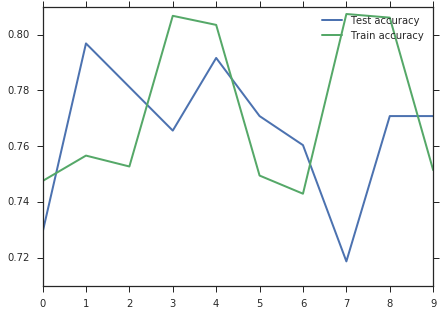

'chosen model at index 4 with distance 0.0118466710041'

In [12]:
from sklearn.utils import shuffle
from  matplotlib import pyplot as plot

import seaborn
seaborn.set(style='ticks')

# Set the parameters by cross-validation

#Whether or not to omit the radius & noise features
radius_test = False

omit = ['TrialNumber']

for i in [True]:
    radius_test=i
    
    if not radius_test:
        omit.append('Radius')
        omit.append('Noise')
        
    models  = cross_validate( train_model, 'PayOffFunction', omit )
    choose_best(models)
    
    ch = None
    score = 999999999
    selected_index = -1
    index = 0
    
    for i in models:
        dist = abs(i.test_score - i.train_score)
        if dist < score:
            score = dist
            ch = i
            selected_index = index
        index = index + 1
            
    display('chosen model at index ' + str(selected_index) + ' with distance ' + str(score))
    
    R = ch.X.copy()

    R['distance'] = ch.model.decision_function(ch.XOriginal)
    R['prediction'] = ch.model.predict(ch.XOriginal)
    R['label'] = ch.labels
    
    t = []
     
    for i in range(0,ch.X.shape[0]):
        t.append(i < ch.test_size)
        
    R['is_test'] = t
    
    R.to_csv('result_data.csv')